In [1]:
# mount to desired path
from google.colab import drive
drive.mount('/content/gdrive')

!pip install tiktoken

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


In [2]:
import tiktoken
import os
import time
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pprint
import re
import seaborn as sns
import pandas as pd

In [3]:
# customize you directory(remember add a shortcut of GE Capstone Project to google drive)
directory = "gdrive/My Drive/GE Capstone/Data/i2b2/testing-PHI-Gold-fixed"

# check dataset
#os.listdir(directory)

In [4]:
# calculate the number of tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# tokenize rewritten text after de-idenfitication as well as original content
def tokenize_text_generation(rewritten_text, text_content):
  rewritten_text_tokens = re.split(r'[\s\t\n]+', rewritten_text)
  rewritten_text_tokens = [x for x in rewritten_text_tokens if x != '']
  original_tokens = re.split(r'[\s\t\n]+', text_content)
  original_tokens = [x for x in original_tokens if x != '']
  return rewritten_text_tokens, original_tokens

# process dataset, parse each xml file into a text and a tag dict
list_of_text_contents = []
list_of_files = []
list_of_tags = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        # print(os.path.basename(os.path.normpath(f))[:-4])
        list_of_files.append(os.path.basename(os.path.normpath(f))[:-4])
        with open(f) as fp:
            tag_list = []
            soup = BeautifulSoup(fp, features="xml")
            text = soup.find('TEXT')
            text_content = text.contents[0]
            list_of_text_contents.append(text_content)
            tags = soup.find('TAGS')
            for item in tags.children:
              try:
                newdict = {"text":item['text'], "type":item["TYPE"]}
                tag_list.append(newdict)
              except:
                pass

            list_of_tags.append(tag_list)


### Text Length Distribution

[Text(0.5, 1.0, 'Distribution of Raw Record Length')]

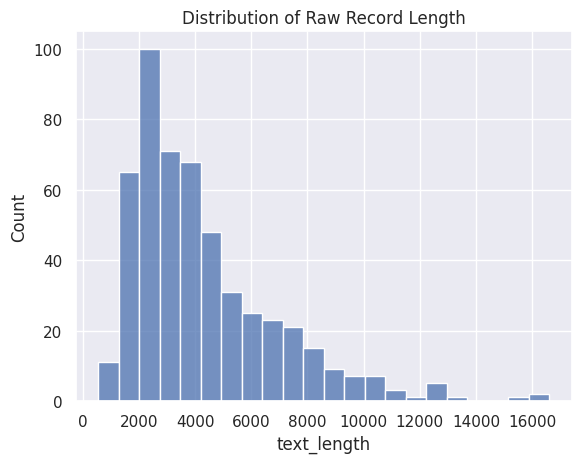

In [5]:
# text length
text_len_list = []
for s in list_of_text_contents:
  text_len_list.append(len(s))

text_len_df = pd.DataFrame(text_len_list, columns=["text_length"] )
#plt.hist(list_of_len)
sns.set(style="darkgrid")
sns.histplot(data=text_len_df, x="text_length").set(title='Distribution of Raw Record Length')

### Tag Distribution

In [6]:
# tag distribution
list_of_tags_flatterned = [item for sublist in list_of_tags for item in sublist]
tag_df = pd.DataFrame(list_of_tags_flatterned)
tags = tag_df["type"].unique()
tags

array(['DATE', 'HOSPITAL', 'STREET', 'PATIENT', 'CITY', 'STATE', 'ZIP',
       'MEDICALRECORD', 'PHONE', 'DOCTOR', 'IDNUM', 'AGE', 'USERNAME',
       'COUNTRY', 'PROFESSION', 'ORGANIZATION', 'FAX', 'DEVICE',
       'LOCATION-OTHER', 'EMAIL'], dtype=object)

In [7]:
len(tag_df[tag_df["type"] == "STATE"]["text"].unique())

55

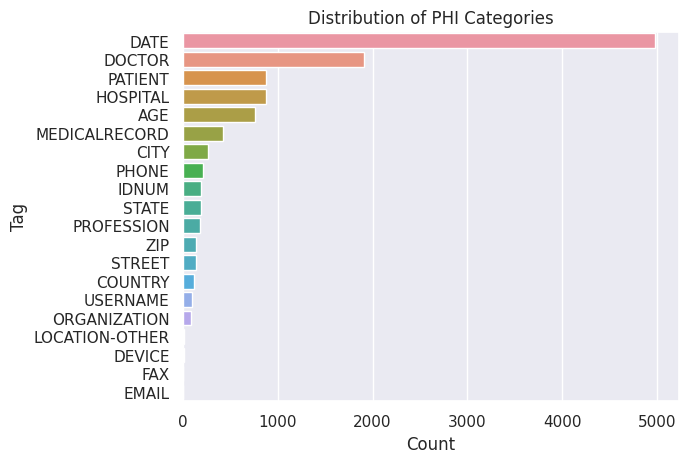

In [8]:
tag_count = tag_df.groupby(by=["type"]).count().reset_index().sort_values(by=['text'], ascending=False)
tag_count = tag_count.rename(columns={"type": "Tag", "text": "Count"})
ax = sns.barplot(tag_count, x="Count", y="Tag").set(title='Distribution of PHI Categories')

In [9]:
tag_uniq_count = tag_df.groupby(by=["type"]).nunique().reset_index()
tag_uniq_count = tag_uniq_count.rename(columns={"type": "Tag", "text": "Unique_Count"})

In [10]:
tag_count_all = pd.merge(tag_count, tag_uniq_count, on="Tag")
tag_count_all = tag_count_all.set_index("Tag")

In [11]:
tag_count_all

,Count,Unique_Count
Tag,,
DATE,4980,2529
DOCTOR,1912,1240
PATIENT,879,434
HOSPITAL,875,426
AGE,764,85
MEDICALRECORD,422,197
CITY,260,152
PHONE,215,187
IDNUM,195,195


<Axes: title={'center': 'Distribution of PHI Categories'}, xlabel='Tag'>

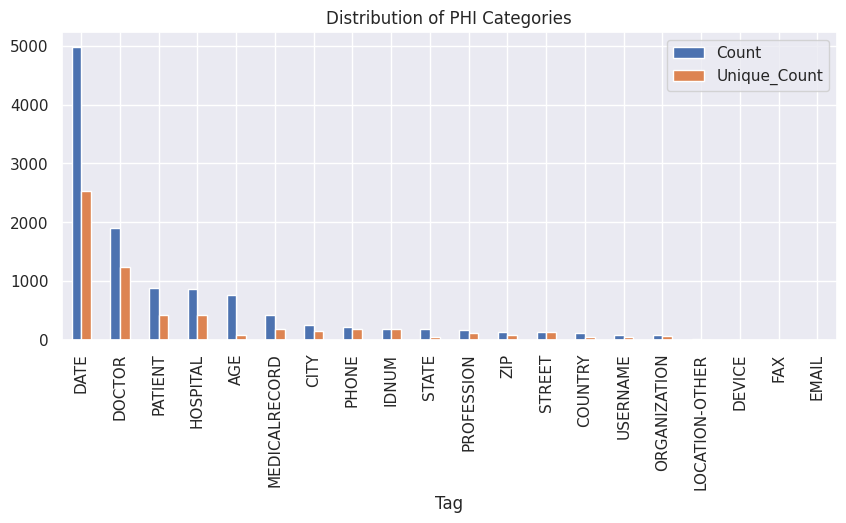

In [12]:
tag_count_all.plot(kind='bar',figsize=(10,4), title = 'Distribution of PHI Categories')
#plt.xticks(rotation=75)

### Word Cloud

In [13]:
#https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(6,6))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()


In [18]:
tag_values = {}
for tag in tags:
   values_L = tag_df[tag_df["type"] == tag]["text"]
   values = " ".join(str(word) for word in values_L)
   tag_values[tag] = values

In [25]:
tag_values["DATE"]

"2083-11-01 11/01/83 10/07/83 11/01/83 11/01/83 11/01/83 2067-07-28 07/28/67 07/28/67 07/28/67 2066-11-14 2062 11/64 11/65 11/66 11/08/2066 Nov 08 8/18/66 Friday Thursday 2067-09-05 9-5-67 June, 2064 6/66 9/61 2063 12/66 5/66 9-5-67 2061 9-5-67 9-6-67 9-5-67 2073-12-03 12/03/73 12/08 2086-05-25 05/25/86 May 25 05/25/86 05/25/86 2096-09-09 9/09/96 Jul 20, 2096 August 31, 2096 2094 2086 2065 9/09/96 9/11/96 2076-04-16 04/16/2076 04/16/76 04/16/76 04/16/76 2085-10-30 4/80 '76 78 74 2085 2088-08-03 2063 08/05/88 08/05/88 2104-09-23 09/23/2104 2102 09/23/04 05/24/22 09/23/04 6/03/04 2092-09-18 1/86 1/84 3/2091 July 2092 November 2091 7/11/92 August 2081 June 2088 9/18/2092 26 Jun 92 5/92 Sep 25, 2092 2096-07-15 01/31/2096 10/03/2095 11/05/2095 07/15/96 January June July 1st July 3rd July 5 2091 2090 January 11/85 Dec 2094 05/24/2095 05/24/2095 05/24/2095 05/24/2095 05/24/2095 05/24/2095 05/24/2095 10/03/2095 05/24/2095 05/24/2095 10/03/2095 10/4/96 05/24/2095 05/24/2095 08/15/2095 05/29/209

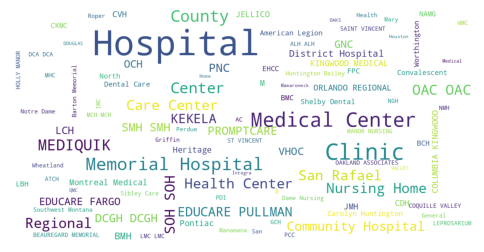

In [26]:
show_wordcloud(tag_values["HOSPITAL"])

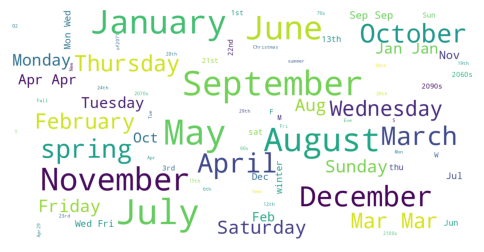

In [21]:
show_wordcloud(tag_values["DATE"])

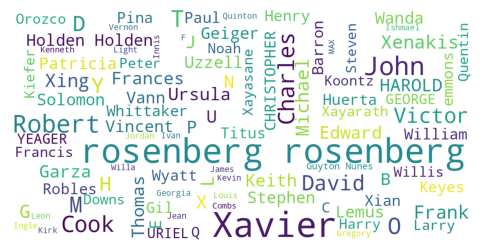

In [22]:
show_wordcloud(tag_values["DOCTOR"])

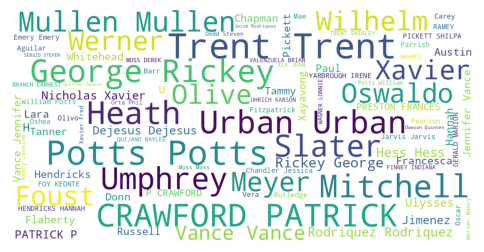

In [23]:
show_wordcloud(tag_values["PATIENT"])

In [ ]:
['DATE', 'HOSPITAL', 'STREET', 'PATIENT', 'CITY', 'STATE', 'ZIP',
       'MEDICALRECORD', 'PHONE', 'DOCTOR', 'IDNUM', 'AGE', 'USERNAME',
       'COUNTRY', 'PROFESSION', 'ORGANIZATION', 'FAX', 'DEVICE',
       'LOCATION-OTHER', 'EMAIL']

# State, age, country